In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [6]:
from sklearn.metrics import accuracy_score

In [7]:
from IPython.display import display, HTML

In [8]:
spark = SparkSession.builder.master('local').appName('Predicting Fire Dept Calls').config('spark.executor.memory','6gb').getOrCreate()

In [9]:
url = 'C:/Users/Dylan/Desktop/Datasets/csv_result-airlines.csv'
df = spark.read.format('com.databricks.spark.csv').options(header='True', inferschema='True').load(url)
df.show()

+---+-------+------+-----------+---------+---------+----+------+-----+
| id|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|
+---+-------+------+-----------+---------+---------+----+------+-----+
|  1|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|
|  2|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|
|  3|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|
|  4|     AA|  2466|        SFO|      DFW|        3|  20|   195|    1|
|  5|     AS|   108|        ANC|      SEA|        3|  30|   202|    0|
|  6|     CO|  1094|        LAX|      IAH|        3|  30|   181|    1|
|  7|     DL|  1768|        LAX|      MSP|        3|  30|   220|    0|
|  8|     DL|  2722|        PHX|      DTW|        3|  30|   228|    0|
|  9|     DL|  2606|        SFO|      MSP|        3|  35|   216|    1|
| 10|     AA|  2538|        LAS|      ORD|        3|  40|   200|    1|
| 11|     CO|   223|        ANC|      SEA|        3|  49|   201|    1|
| 12| 

In [10]:
df = df.toPandas()
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [11]:
df = df.drop(['id'], axis=1)
df.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269,SFO,IAH,3,15,205,1
1,US,1558,PHX,CLT,3,15,222,1
2,AA,2400,LAX,DFW,3,20,165,1
3,AA,2466,SFO,DFW,3,20,195,1
4,AS,108,ANC,SEA,3,30,202,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Airline      539383 non-null  object
 1   Flight       539383 non-null  int32 
 2   AirportFrom  539383 non-null  object
 3   AirportTo    539383 non-null  object
 4   DayOfWeek    539383 non-null  int32 
 5   Time         539383 non-null  int32 
 6   Length       539383 non-null  int32 
 7   Delay        539383 non-null  int32 
dtypes: int32(5), object(3)
memory usage: 22.6+ MB


In [13]:
df.describe()

,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,2427.928630,3.929668,802.728963,132.202007,0.445442
std,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,10.000000,0.000000,0.000000
25%,712.000000,2.000000,565.000000,81.000000,0.000000
50%,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [14]:
df.shape

(539383, 8)

Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

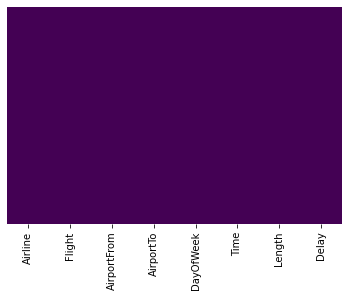

In [15]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
df.isnull().sum()

In [16]:
len(df)-len(df.drop_duplicates())

216618

0    299119
1    240264
Name: Delay, dtype: int64

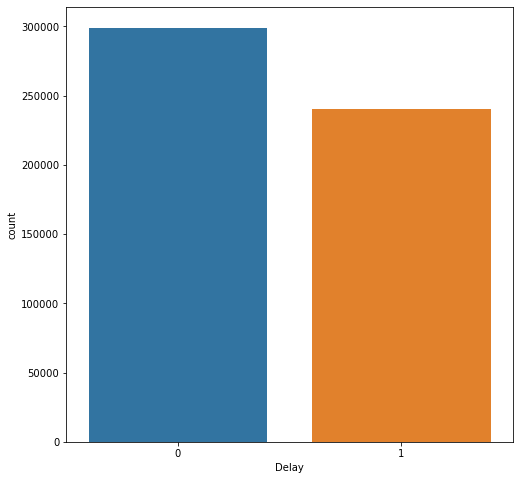

In [17]:
fig = plt.subplots(figsize=(8,8))
sns.countplot(x=df['Delay'])
df['Delay'].value_counts()

ATL    34449
ORD    24822
DFW    22154
DEN    19843
LAX    16657
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportFrom, Length: 293, dtype: int64
Total Number of Airports to Depart From: 293


<AxesSubplot:title={'center':'Distribution of the bottom 5 Airports being descended From'}, xlabel='Airport From', ylabel='Count'>

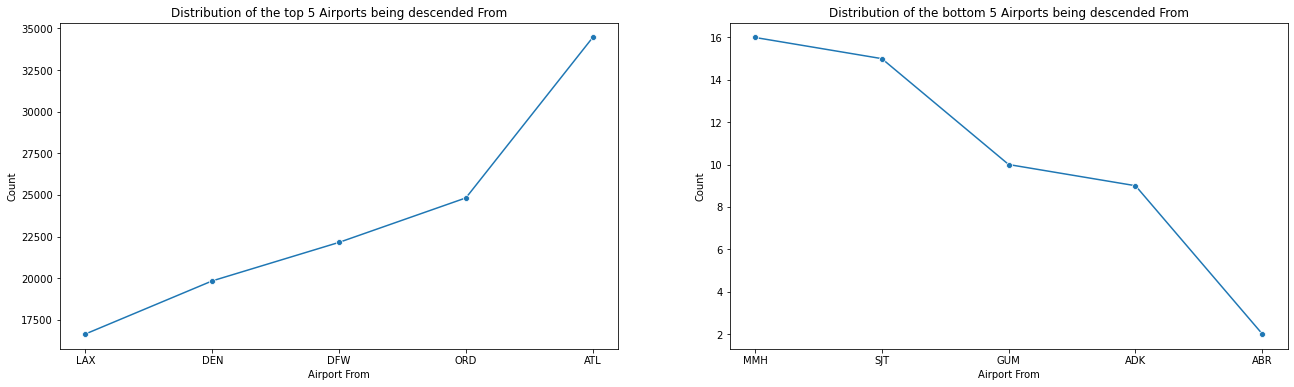

In [18]:
totalNumber = len(df['AirportFrom'].value_counts())
display(HTML("<h1>Airports being descended from</h1>"))
print(df['AirportFrom'].value_counts())
print(f"Total Number of Airports to Depart From: {totalNumber}")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,6)) 
ax1.set_title('Distribution of the top 5 Airports being descended From')
ax1.set_xlabel('Airport From')
ax1.set_ylabel('Count')
ax2.set_title('Distribution of the bottom 5 Airports being descended From')
ax2.set_xlabel('Airport From')
ax2.set_ylabel('Count')
sns.lineplot(data=df['AirportFrom'].value_counts().nlargest(5)[::-1], dashes=True, marker='o', ax=ax1)
sns.lineplot(data=df['AirportFrom'].value_counts().nsmallest(5)[::-1], dashes='true', marker='o', ax=ax2)

ATL    34440
ORD    24871
DFW    22153
DEN    19848
LAX    16656
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportTo, Length: 293, dtype: int64
Total Number of Airports to Depart To: 293


<AxesSubplot:title={'center':'Distribution of the bottom 5 Airports being ascended To'}, xlabel='Airport To', ylabel='Count'>

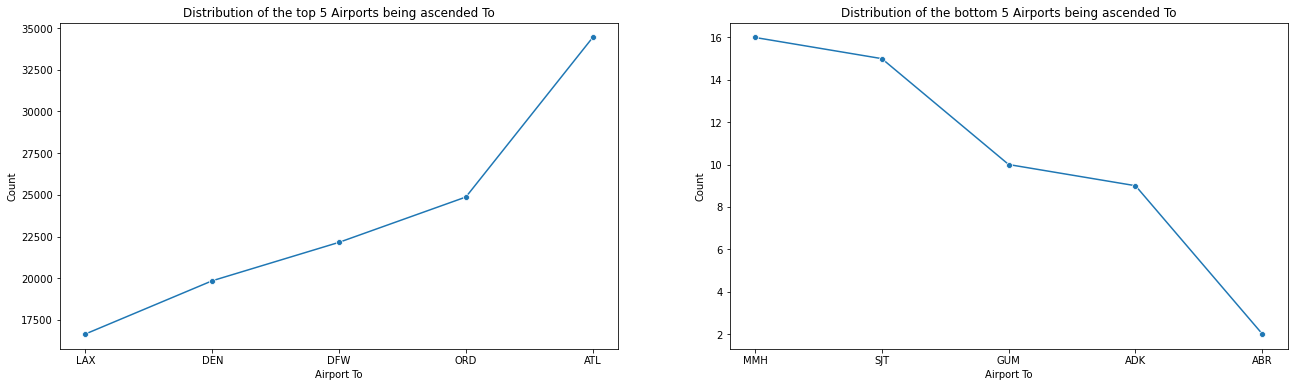

In [19]:
totalNumber = len(df['AirportTo'].value_counts())
display(HTML("<h1>Top 5 Airports being ascended To</h1>"))
print(df['AirportTo'].value_counts())
print(f"Total Number of Airports to Depart To: {totalNumber}")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,6)) 
ax1.set_title('Distribution of the top 5 Airports being ascended To')
ax1.set_xlabel('Airport To')
ax1.set_ylabel('Count')
ax2.set_title('Distribution of the bottom 5 Airports being ascended To')
ax2.set_xlabel('Airport To')
ax2.set_ylabel('Count')
sns.lineplot(data=df['AirportTo'].value_counts().nlargest(5)[::-1], dashes=True, marker='o', ax=ax1)
sns.lineplot(data=df['AirportTo'].value_counts().nsmallest(5)[::-1], dashes='true', marker='o', ax=ax2)

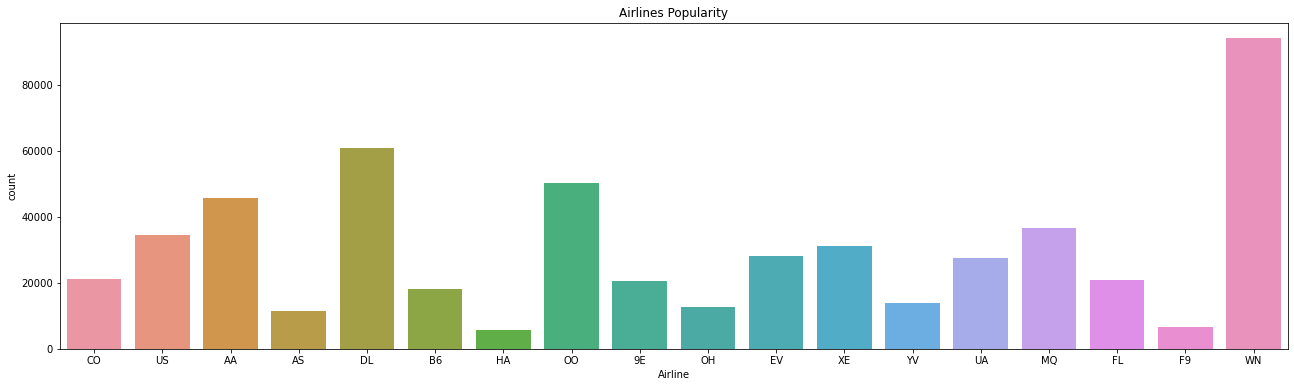

In [20]:
fig = plt.subplots(figsize=(22,6))
plt.title('Airlines Popularity')
df['Airline'].value_counts()
sns.countplot(x=df['Airline'])
plt.show()

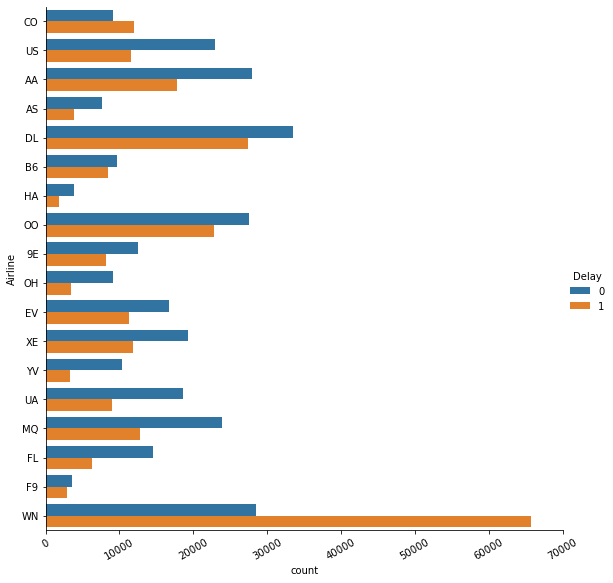

In [21]:
#fig = plt.subplots(figsize=(22,6))
#plt.title('The total count of Airlines that have been Delayed and Not Delayed')
fig = sns.catplot(data=df, y='Airline', hue='Delay', kind='count', orient='V', height=8)
fig.set_xticklabels(rotation=30)
plt.show()

<Figure size 1296x720 with 0 Axes>

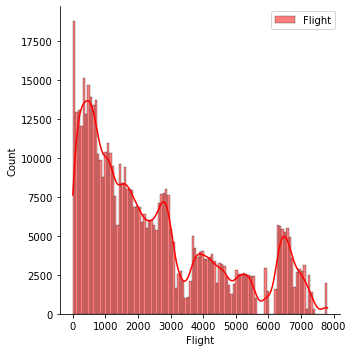

<Figure size 1296x720 with 0 Axes>

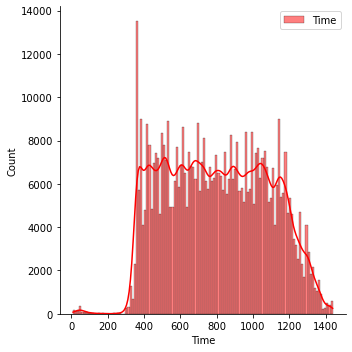

<Figure size 1296x720 with 0 Axes>

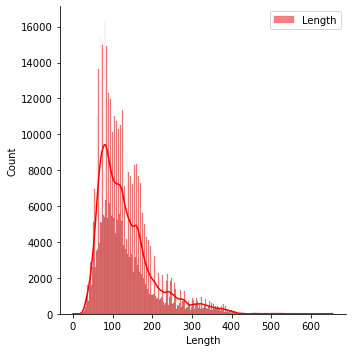

In [22]:
Airlines_Numerical = ['Flight','Time','Length']
for col in Airlines_Numerical:
    plt.figure(figsize=(18,10))
    sns.displot(df[col], color='red', label=col, kde=True)
    plt.legend()

<AxesSubplot:title={'center':'Distribution of the Flight Length over Delayed or Not Delayed'}, xlabel='Length', ylabel='Delay'>

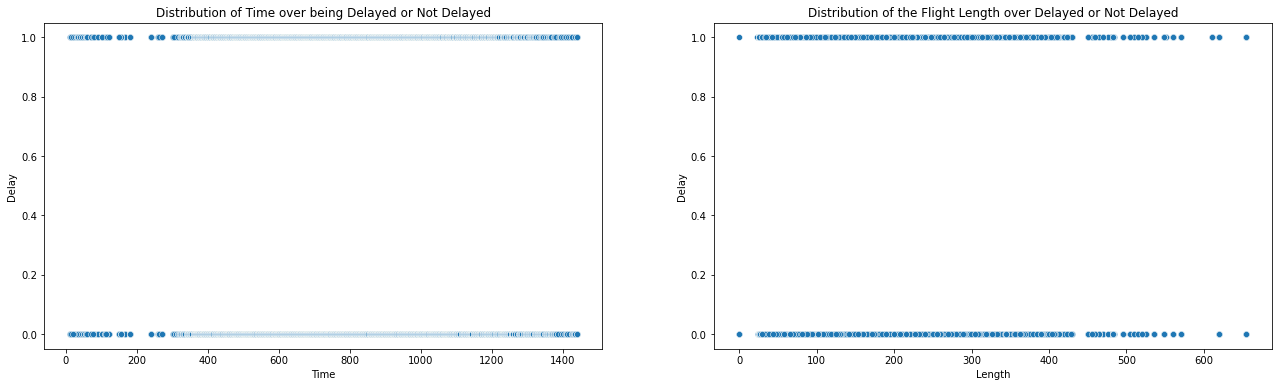

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(22,6)) 
ax1.set_title('Distribution of Time over being Delayed or Not Delayed')
ax1.set_xlabel('Time')
ax1.set_ylabel('Delay')

ax2.set_title('Distribution of the Flight Length over Delayed or Not Delayed')
ax2.set_xlabel('Length')
ax2.set_ylabel('Delay')

sns.scatterplot(data=df, x='Time', y='Delay',ax=ax1)
sns.scatterplot(data=df, x='Length', y='Delay',ax=ax2)


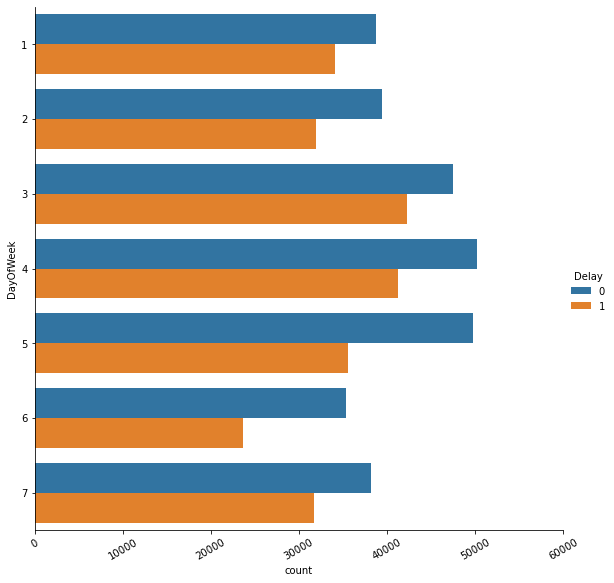

In [24]:
fig = sns.catplot(data=df, y='DayOfWeek', hue='Delay', kind='count', orient='V', height=8)
fig.set_xticklabels(rotation=30)
plt.show()

In [25]:
Airlines_Categorical = ['Airline','AirportFrom','AirportTo']
for x in Airlines_Categorical:
    df[x] = LabelEncoder().fit_transform(df[x])

In [26]:
df.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,4,269,253,135,3,15,205,1
1,14,1558,217,60,3,15,222,1
2,1,2400,154,80,3,20,165,1
3,1,2466,253,80,3,20,195,1
4,2,108,14,252,3,30,202,0


In [27]:
df.corr()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
Airline,1.000000,0.095285,0.098237,0.098791,-0.007258,0.004381,-0.207061,0.066936
Flight,0.095285,1.000000,-0.021802,-0.022072,0.000416,-0.005750,-0.341481,-0.046175
AirportFrom,0.098237,-0.021802,1.000000,0.015139,0.003732,-0.031555,0.049698,0.018459
AirportTo,0.098791,-0.022072,0.015139,1.000000,0.003846,0.030599,0.086982,0.047990
DayOfWeek,-0.007258,0.000416,0.003732,0.003846,1.000000,0.001273,0.013397,-0.026199
Time,0.004381,-0.005750,-0.031555,0.030599,0.001273,1.000000,-0.020612,0.150454
Length,-0.207061,-0.341481,0.049698,0.086982,0.013397,-0.020612,1.000000,0.040489
Delay,0.066936,-0.046175,0.018459,0.047990,-0.026199,0.150454,0.040489,1.000000


<AxesSubplot:>

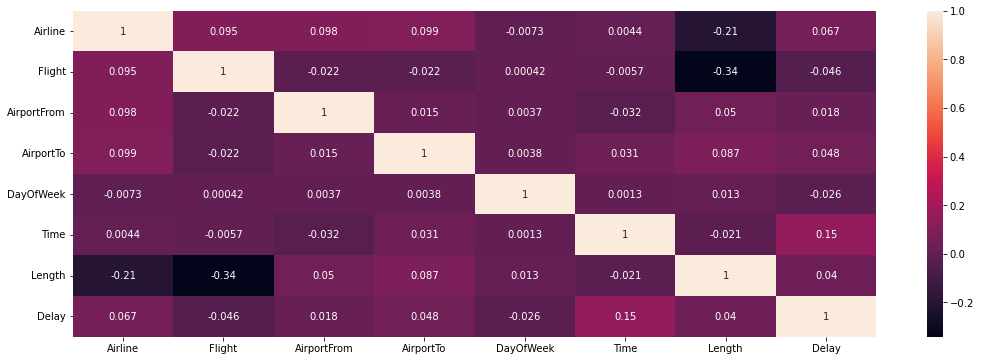

In [28]:
fig = plt.subplots(figsize=(18,6))
sns.heatmap(df.corr(),annot=True)

In [29]:
df.columns

Index(['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time',
       'Length', 'Delay'],
      dtype='object')

In [30]:
y = df['Delay']
y.head()

0    1
1    1
2    1
3    1
4    0
Name: Delay, dtype: int32

In [31]:
X = df[['Airline','Flight','AirportFrom','AirportTo','DayOfWeek','Time','Length']]
X.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length
0,4,269,253,135,3,15,205
1,14,1558,217,60,3,15,222
2,1,2400,154,80,3,20,165
3,1,2466,253,80,3,20,195
4,2,108,14,252,3,30,202


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
    )